In [19]:
import pandas as pd
import unicodedata
import re


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
df=pd.read_csv('../data/master_oscar_1.csv', encoding='ISO-8859-1')
df.head()

,ceremony_year,ceremony,award_category,name,film,status
0,2025,97th,Actor in a Leading Role,Adrien Brody,The Brutalist,Won
1,2025,97th,Actor in a Supporting Role,Kieran Culkin,A Real Pain,Won
2,2025,97th,Actress in a Leading Role,Mikey Madison,Anora,Won
3,2025,97th,Actress in a Supporting Role,Zoe Saldaa,Emilia Prez,Won
4,2025,97th,Animated Feature Film,"Gints Zilbalodis, Mat_ss Ka_a, Ron Dyens and G...",Flow,Won


In [21]:
def clean_all_text(text):
    if not isinstance(text, str):
        return text
        
    # REMOVE problematic Unicode control characters (not replace with space)
    text = re.sub(r'[\x80-\x9f\xa0]', '', text)
    
    # Normalize to decompose characters (é → e +  ́)
    text = unicodedata.normalize('NFKD', text)
    
    # If a character can’t be encoded in ASCII (like é, ü, ç), just drop it.
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Remove leftover non-ASCII characters, if any
    text = re.sub(r'[^\x00-\x7F]', '', text)
    
    # Collapse multiple spaces and trim
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [22]:
# Apply to every cell in the DataFrame using `apply` across columns
df_cleaned = df.apply(lambda col: col.map(clean_all_text))
df_cleaned

,ceremony_year,ceremony,award_category,name,film,status
0,2025,97th,Actor in a Leading Role,Adrien Brody,The Brutalist,Won
1,2025,97th,Actor in a Supporting Role,Kieran Culkin,A Real Pain,Won
2,2025,97th,Actress in a Leading Role,Mikey Madison,Anora,Won
3,2025,97th,Actress in a Supporting Role,Zoe Saldaa,Emilia Prez,Won
4,2025,97th,Animated Feature Film,"Gints Zilbalodis, Mat_ss Ka_a, Ron Dyens and G...",Flow,Won
...,...,...,...,...,...,...
10977,1928,1st,Writing (Title Writing),Gerald Duffy,The Private Life of Helen of Troy,Nominated
10978,1928,1st,Writing (Title Writing),Joseph Farnham,NaN,Won
10979,1928,1st,Writing (Title Writing),"George Marion, Jr.",NaN,Nominated
10980,1928,1st,Special Award,Warner Bros.,NaN,Won


In [23]:
df_cleaned.to_csv("../data/Cleaned_Felix.csv")

##### Problem Statement : We are a team of data scientists consulting film directors who want to increase their chances of winning an Oscar. We will provide insights into whether a movie is likely to win in at least one of the 23 Oscar categories. Using multiple datasets of past Oscar-nominated and winning films, we will build a binary classification model to predict Oscar successes based on features such as genre, runtime, IMDb rating, etc. The model will be evaluated using accuracy, precision, recall, and F1 score. 

In [25]:
merged_df =  pd.read_csv("../data/final.csv")

In [26]:
merged_df.head()

,film,ceremony,actor_in_a_leading_role,actor_in_a_supporting_role,actress_in_a_leading_role,actress_in_a_supporting_role,animated_feature_film,animated_short_film,best_picture,cinematography,...,nominated_international_feature,nominated_makeup_and_hairstyling,nominated_music,nominated_other,nominated_picture,nominated_production_design,nominated_short_film,nominated_sound,nominated_visual_effects,nominated_writing
0,Round Midnight,59th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,10,52nd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,0,0,0,0,0,0,0
2,102 Dalmatians,73rd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,12,80th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,12 Angry Men,30th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0


In [27]:
merged_df.isnull().sum()

film                           0
ceremony                       0
actor_in_a_leading_role        0
actor_in_a_supporting_role     0
actress_in_a_leading_role      0
                              ..
nominated_production_design    0
nominated_short_film           0
nominated_sound                0
nominated_visual_effects       0
nominated_writing              0
Length: 78, dtype: int64

In [28]:
merged_df.dtypes

film                            object
ceremony                        object
actor_in_a_leading_role        float64
actor_in_a_supporting_role     float64
actress_in_a_leading_role      float64
                                ...   
nominated_production_design      int64
nominated_short_film             int64
nominated_sound                  int64
nominated_visual_effects         int64
nominated_writing                int64
Length: 78, dtype: object

In [29]:
merged_df['won'].value_counts(normalize=True)

won
0    0.7298
1    0.2702
Name: proportion, dtype: float64

In [30]:
merged_df['title_type'].value_counts()

title_type
Movie        3549
Short        1073
TV Movie       13
Video           3
TV Short        2
TV Series       1
Name: count, dtype: int64

In [31]:
merged_df['ceremony'].value_counts()

ceremony
14th    91
15th    85
17th    78
18th    77
16th    76
        ..
5th     21
4th     19
2nd     14
96th    13
1st      8
Name: count, Length: 97, dtype: int64

In [32]:
merged_df['film'].value_counts()

film
Little Women                 4
A Star Is Born               4
Hamlet                       3
The Jungle Book              3
The Last Of The Mohicans     2
                            ..
I, Robot                     1
I, Tonya                     1
Icarus                       1
Icarus Montgolfier Wright    1
Tom Thumb                    1
Name: count, Length: 4552, dtype: int64

# I am going to choose only those features before the oscar outcome is known, 'IMDb Rating', 'runtime_mins', 'year', 'num_votes', 'genres', 'title_type'

In [34]:
features = ['imdb_rating', 'runtime_mins', 'year', 'num_votes', 'title_type']
numeric_features = ['imdb_rating', 'runtime_mins', 'year', 'num_votes']
categorical_features = ['title_type']
X = merged_df[features]
y = merged_df['won']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
numeric_transformer = Pipeline(steps=[('imputer', IterativeImputer(random_state=42))])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42))
])
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['imdb_rating',
                                                   'runtime_mins', 'year',
                                                   'num_votes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['title_type'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [36]:
y_pred = clf_pipeline.predict(X_test)
print("Classification Report (Base Model):\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report (Base Model):
               precision    recall  f1-score   support

           0       0.77      0.92      0.84       678
           1       0.55      0.27      0.36       251

    accuracy                           0.74       929
   macro avg       0.66      0.59      0.60       929
weighted avg       0.71      0.74      0.71       929

Confusion Matrix:
 [[623  55]
 [184  67]]


In [37]:
feature_names = (
    numeric_features +
    list(clf_pipeline.named_steps['preprocessor']
         .transformers_[1][1]
         .named_steps['encoder']
         .get_feature_names_out(categorical_features))
)
importances = clf_pipeline.named_steps['classifier'].feature_importances_
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top 10 Important Features:\n", feature_importances.head(10))

Top 10 Important Features:
 num_votes               0.339977
runtime_mins            0.231844
year                    0.231217
imdb_rating             0.185856
title_type_Movie        0.005161
title_type_Short        0.004851
title_type_TV Movie     0.000544
title_type_TV Short     0.000369
title_type_Video        0.000146
title_type_TV Series    0.000035
dtype: float64


In [38]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}
grid_search = GridSearchCV(clf_pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
y_pred_best = best_model.predict(X_test)
print("Best Parameters:", best_params)
print("\nClassification Report (Tuned):\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix (Tuned):\n", confusion_matrix(y_test, y_pred_best))

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.77      0.91      0.84       678
           1       0.55      0.28      0.37       251

    accuracy                           0.74       929
   macro avg       0.66      0.60      0.60       929
weighted avg       0.71      0.74      0.71       929


Confusion Matrix (Tuned):
 [[620  58]
 [181  70]]


#### Class Imbalance: There are more non-winners (0) than winners (1), making recall for winners lower.

#### The model is good at identifying movies that won't win, but misses some that could win.

#### Predictive signals: Higher IMDb rating, runtime, and vote count correlate with winning likelihood.

#### genres & title_type can also influence — e.g., drama vs. action, short vs. feature.

In [40]:
from sklearn.ensemble import ExtraTreesClassifier

# Add ExtraTreesClassifier to model list
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Build pipeline with preprocessing and ExtraTrees
et_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', et_model)
])

# Fit and evaluate ExtraTrees
et_pipeline.fit(X_train, y_train)
et_pred = et_pipeline.predict(X_test)

# Generate classification report
et_report = classification_report(y_test, et_pred, output_dict=True)

# Convert to DataFrame for display
et_results_df = pd.DataFrame(et_report).T
et_results_df

,precision,recall,f1-score,support
0,0.770964,0.908555,0.834123,678.000000
1,0.523077,0.270916,0.356955,251.000000
accuracy,0.736276,0.736276,0.736276,0.736276
macro avg,0.647020,0.589735,0.595539,929.000000
weighted avg,0.703989,0.736276,0.705201,929.000000


In [41]:
from xgboost import XGBClassifier
# Define XGBoost pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       687
           1       0.48      0.29      0.37       242

    accuracy                           0.73       929
   macro avg       0.63      0.59      0.60       929
weighted avg       0.70      0.73      0.71       929



In [42]:
merged_df.isnull().sum()

film                           0
ceremony                       0
actor_in_a_leading_role        0
actor_in_a_supporting_role     0
actress_in_a_leading_role      0
                              ..
nominated_production_design    0
nominated_short_film           0
nominated_sound                0
nominated_visual_effects       0
nominated_writing              0
Length: 78, dtype: int64

In [43]:
merged_df.dropna(inplace=True)

In [44]:
merged_df.isnull().sum()

film                           0
ceremony                       0
actor_in_a_leading_role        0
actor_in_a_supporting_role     0
actress_in_a_leading_role      0
                              ..
nominated_production_design    0
nominated_short_film           0
nominated_sound                0
nominated_visual_effects       0
nominated_writing              0
Length: 78, dtype: int64

In [45]:
features = ['imdb_rating', 'runtime_mins', 'year', 'num_votes', 'title_type']
numeric_features = ['imdb_rating', 'runtime_mins', 'year', 'num_votes']
categorical_features = ['title_type']
X = merged_df[features]
y = merged_df['won']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define full pipeline with logistic regression
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit and predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print evaluation metrics
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.96      0.83       657
           1       0.50      0.10      0.17       250

    accuracy                           0.72       907
   macro avg       0.62      0.53      0.50       907
weighted avg       0.67      0.72      0.65       907



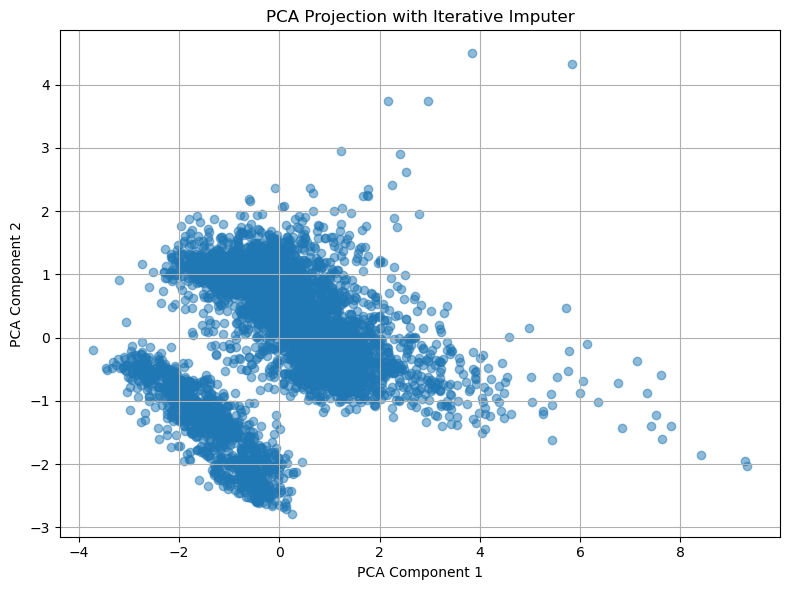

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

numeric_features = ['imdb_rating', 'runtime_mins', 'year', 'num_votes']
categorical_features = ['title_type']

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Create a PCA DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

# Plot PCA projection
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], alpha=0.5)
plt.title("PCA Projection with Iterative Imputer")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

Clear Clustering/Grouping:

The data appears to form several dense blobs, suggesting underlying structure — possibly different genres, production types, or budget ranges.

The two main groups (center and lower left) could represent:

Oscar-winning style films vs commercial blockbusters.

High vs low IMDb ratings or vote counts.

Component 1 (x-axis):

Likely captures overall popularity or scale — correlated with features like IMDb Rating, num_votes, Runtime.

Points farther to the right may represent high-rated, widely seen movies.

Component 2 (y-axis):

Captures a secondary factor, possibly genre variation or release year clusters.

Spread in vertical direction may relate to categorical diversity (e.g., documentary vs feature film).

In [49]:
df1 = pd.read_csv('../data/final.csv')
df1

,film,ceremony,actor_in_a_leading_role,actor_in_a_supporting_role,actress_in_a_leading_role,actress_in_a_supporting_role,animated_feature_film,animated_short_film,best_picture,cinematography,...,nominated_international_feature,nominated_makeup_and_hairstyling,nominated_music,nominated_other,nominated_picture,nominated_production_design,nominated_short_film,nominated_sound,nominated_visual_effects,nominated_writing
0,Round Midnight,59th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,10,52nd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,0,0,0,0,0,0,0
2,102 Dalmatians,73rd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,12,80th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,12 Angry Men,30th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4636,Images,45th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4637,"Sex, Lies, And Videotape",62nd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4638,The Accountant,74th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4639,The End,68th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


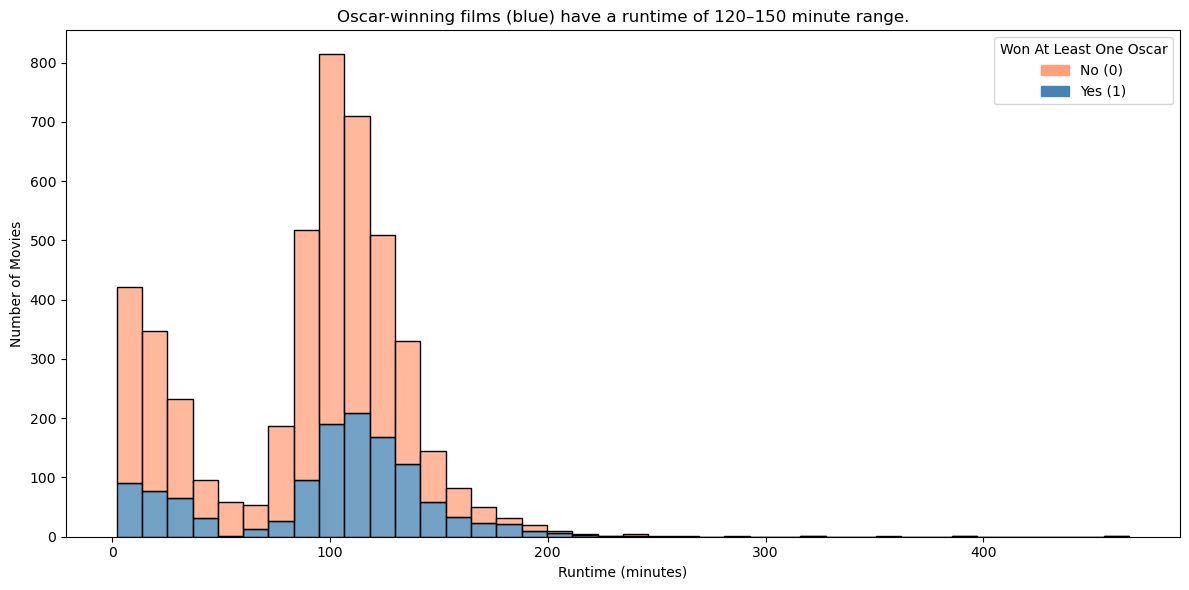

In [50]:
import seaborn as sns
import matplotlib.patches as mpatches

custom_palette = {0: "#FFA07A", 1: "#4682B4"}

# Define manual legend handles again
no_win_patch = mpatches.Patch(color=custom_palette[0], label="No (0)")
yes_win_patch = mpatches.Patch(color=custom_palette[1], label="Yes (1)")

# Re-plot with fixed palette
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df1,
    x="runtime_mins",
    hue="won",
    bins=40,
    multiple="stack",
    palette=custom_palette,
    kde=False,
    stat="count",
    hue_order=[0, 1]
)

plt.title("Oscar-winning films (blue) have a runtime of 120–150 minute range.")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Number of Movies")
plt.legend(handles=[no_win_patch, yes_win_patch], title="Won At Least One Oscar")
plt.tight_layout()
plt.show()

### Oscar-winning films (blue) have a runtime of 120–150 minute range.